In [ ]:
import os
import math
import hashlib
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from dataclasses import dataclass
from typing import List

TARGET_IMG_PATH = r"D:\GIT\Thesis\experiment2\generatedTestImg\generatedTestImg.png"
OUTPUT_DIR = "experiment_results_heatmap"
os.makedirs(OUTPUT_DIR, exist_ok=True)

PAYLOAD_STR = "EU01A1BG5T20251027ABCD"

print(f"Target Image: {TARGET_IMG_PATH}")
print(f"Payload: {PAYLOAD_STR}")

Target Image: D:\GIT\Thesis\experiment2\generatedTestImg\generatedTestImg.png
Payload: EU01A1BG5T20251027ABCD


In [29]:
# --------- ECC Functions ---------
def payload_to_32bits(s: str) -> List[int]:
    h = hashlib.sha256(s.encode("ascii")).digest()
    v = int.from_bytes(h[:4], "big")
    bits = [(v >> (31 - i)) & 1 for i in range(32)]
    return bits

def hamming74_encode_block(n4: List[int]) -> List[int]:
    d1, d2, d3, d4 = n4
    p1 = d1 ^ d2 ^ d4
    p2 = d1 ^ d3 ^ d4
    p3 = d2 ^ d3 ^ d4
    return [p1, p2, d1, p3, d2, d3, d4]

def hamming74_encode(bits: List[int]):
    pad = (4 - (len(bits) % 4)) % 4
    bits_padded = bits + [0] * pad
    out = []
    for i in range(0, len(bits_padded), 4):
        out.extend(hamming74_encode_block(bits_padded[i:i+4]))
    return out, pad

def repeat_bits(bits: List[int], r: int) -> List[int]:
    return [b for bit in bits for b in [bit] * r]

# --------- Decoding ---------
def majority_vote(groups: List[List[int]]) -> List[int]:
    return [1 if sum(g) * 2 >= len(g) else 0 for g in groups]

def hamming74_decode_block(c7: List[int]):
    p1, p2, d1, p3, d2, d3, d4 = c7
    s1 = p1 ^ d1 ^ d2 ^ d4
    s2 = p2 ^ d1 ^ d3 ^ d4
    s3 = p3 ^ d2 ^ d3 ^ d4
    syndrome = (s3 << 2) | (s2 << 1) | s1
    if syndrome != 0 and 1 <= syndrome <= 7:
        c7[syndrome - 1] ^= 1
    return [c7[2], c7[4], c7[5], c7[6]]

def hamming74_decode(bits: List[int], pad: int):
    out = []
    for i in range(0, len(bits), 7):
        out.extend(hamming74_decode_block(bits[i:i+7]))
    if pad:
        out = out[:-pad]
    return out

# Calculate Reference Checksum
bits32 = payload_to_32bits(PAYLOAD_STR)
ref_int = int("".join(str(b) for b in bits32), 2)
print(f"Reference Checksum (Int): {ref_int}")

Reference Checksum (Int): 3625187521


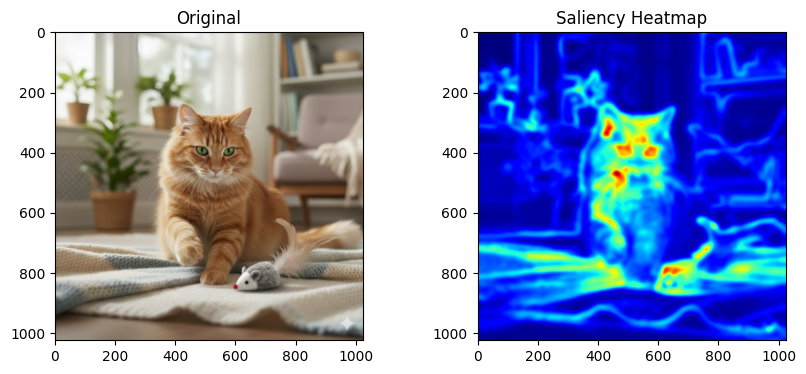

In [30]:
def get_saliency_heatmap(img_bgr: np.ndarray) -> np.ndarray:
    """
    Generates a normalized importance map (0.0 to 1.0).
    High values = Edges/Texture/Important Objects.
    Low values = Flat background.
    """
    # 1. Convert to Gray
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    
    # 2. Gradient Magnitude (Texture detection)
    gx = cv2.Sobel(gray, cv2.CV_32F, 1, 0, ksize=3)
    gy = cv2.Sobel(gray, cv2.CV_32F, 0, 1, ksize=3)
    magnitude = cv2.magnitude(gx, gy)
    
    # 3. Blur heavily to create a "Region" of interest rather than just lines
    heatmap = cv2.GaussianBlur(magnitude, (51, 51), 0)
    
    # 4. Normalize to 0.0 - 1.0 range
    min_val, max_val = heatmap.min(), heatmap.max()
    if max_val - min_val > 0:
        heatmap = (heatmap - min_val) / (max_val - min_val)
    else:
        heatmap = np.zeros_like(heatmap)
        
    return heatmap

# Load and Test Heatmap
if os.path.exists(TARGET_IMG_PATH):
    test_img = cv2.imread(TARGET_IMG_PATH)
    heatmap = get_saliency_heatmap(test_img)
    
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1); plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)); plt.title("Original")
    plt.subplot(1, 2, 2); plt.imshow(heatmap, cmap='jet'); plt.title("Saliency Heatmap")
    plt.show()
else:
    print("Image not found, skipping visualization.")

In [31]:
@dataclass
class Config:
    alpha: float = 4.0      # Base strength
    repeat: int = 5         # Repetitions
    seed: int = 20251120

def gen_noise(h, w, seed):
    rng = np.random.RandomState(seed)
    return rng.choice([-1.0, 1.0], size=(h, w))

def embed_saliency(img_bgr, payload_bits, cfg: Config):
    # 1. Prepare Data
    ecc_bits, pad = hamming74_encode(payload_bits)
    bits_rep = repeat_bits(ecc_bits, cfg.repeat)
    
    # 2. Get Heatmap
    heatmap = get_saliency_heatmap(img_bgr)
    
    # 3. Convert to YCrCb (We embed in Y)
    ycrcb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2YCrCb)
    y, cr, cb = cv2.split(ycrcb)
    y = y.astype(np.float32)
    
    H, W = y.shape
    n_bits = len(bits_rep)
    
    # 4. Define Grid
    tile_w = W // n_bits
    energy_map = np.zeros_like(y)

    for i, bit in enumerate(bits_rep):
        x0 = i * tile_w
        x1 = x0 + tile_w
        if x1 > W: break
        
        # Region
        roi_heatmap = heatmap[:, x0:x1]
        
        # --- FIX 1: Minimum Strength Floor ---
        # Don't let weight go to 0. Keep at least 30% strength in background.
        # This ensures bits aren't completely lost in flat areas.
        weight_map = np.maximum(roi_heatmap, 0.3)
        
        # Generate Noise
        noise = gen_noise(H, tile_w, cfg.seed + i)
        
        direction = 1.0 if bit == 1 else -1.0
        
        # Apply Signal
        delta = cfg.alpha * direction * noise * weight_map
        
        y[:, x0:x1] += delta
        energy_map[:, x0:x1] = np.abs(delta)

    # 5. Merge
    y = np.clip(y, 0, 255).astype(np.uint8)
    res = cv2.merge([y, cr, cb])
    return cv2.cvtColor(res, cv2.COLOR_YCrCb2BGR), energy_map, pad

# RUN EMBEDDING
cfg = Config(alpha=5.0, repeat=5) # Increased alpha slightly for robustness
original = cv2.imread(TARGET_IMG_PATH)

if original is None:
    raise ValueError(f"Image not found at {TARGET_IMG_PATH}")

watermarked_bgr, encoded_map, pad_val = embed_saliency(original, bits32, cfg)

# Save
wm_path = os.path.join(OUTPUT_DIR, "watermarked_heatmap.png")
cv2.imwrite(wm_path, watermarked_bgr)
print(f"Saved to: {wm_path}")

Saved to: experiment_results_heatmap\watermarked_heatmap.png


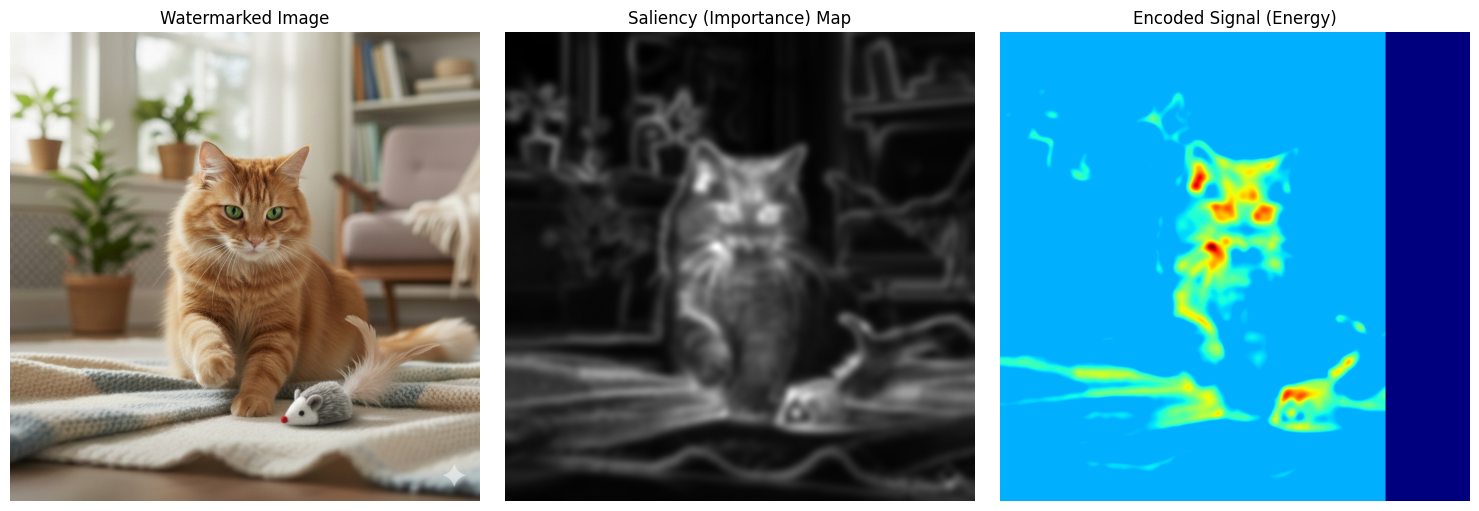

In [32]:
# Visualize
plt.figure(figsize=(15, 5))

# 1. Final Watermarked Image
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(watermarked_bgr, cv2.COLOR_BGR2RGB))
plt.title("Watermarked Image")
plt.axis('off')

# 2. Saliency Heatmap (Where we allowed embedding)
hm = get_saliency_heatmap(original)
plt.subplot(1, 3, 2)
plt.imshow(hm, cmap='gray')
plt.title("Saliency (Importance) Map")
plt.axis('off')

# 3. "Blue Channel" Encoding Visualization
# Actually showing the added noise energy, which looks like the requested 'blue channel' inspection
plt.subplot(1, 3, 3)
plt.imshow(encoded_map, cmap='jet')
plt.title("Encoded Signal (Energy)")
plt.axis('off')

plt.tight_layout()
plt.show()

In [33]:
def detect_saliency(img_bgr, n_bits_payload, pad, cfg: Config):
    # 1. Convert to Y (Luminance)
    ycrcb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2YCrCb)
    y = cv2.split(ycrcb)[0].astype(np.float32)
    H, W = y.shape
    
    # 2. Reconstruct Grid Logic EXACTLY as in Embedding
    # Hamming encoding expands every 4 bits to 7.
    # We need to calculate the intermediate length (ECC bits)
    # The 'pad' tells us if the original 32 bits needed padding to be divisible by 4.
    
    # Calculate how many 4-bit blocks we had
    n_nibbles = math.ceil(n_bits_payload / 4)
    n_ecc_bits = n_nibbles * 7
    total_slots = n_ecc_bits * cfg.repeat
    
    tile_w = W // total_slots
    
    detected_soft_bits = []
    
    # 3. Extraction Loop
    for i in range(total_slots):
        x0 = i * tile_w
        x1 = x0 + tile_w
        
        # Safety check matching embedding loop
        if x1 > W: 
            # Fill remaining expected bits with 0 (neutral) or break
            # Breaking is safer if embedding broke there too
            break
        
        roi = y[:, x0:x1]
        
        # Regenerate exact same noise pattern
        noise = gen_noise(H, tile_w, cfg.seed + i)
        
        # Correlation: Dot product of Image ROI and Noise Pattern
        # Positive sum = Bit 1, Negative sum = Bit 0
        raw_score = np.sum(roi * noise)
        
        detected_soft_bits.append(raw_score)

    # 4. Decoding
    
    # A. Majority Vote (Repetition Code)
    # We sum the raw scores for the repeated blocks. 
    # If the total sum is > 0, it's a 1.
    final_ecc_bits = []
    
    # Process in chunks of 'cfg.repeat'
    for i in range(0, len(detected_soft_bits), cfg.repeat):
        chunk = detected_soft_bits[i:i+cfg.repeat]
        
        # If we have a partial chunk at the end (shouldn't happen if aligned), skip
        if len(chunk) < cfg.repeat:
            break
            
        # Summing soft scores is better than hard voting (Soft Decoding)
        block_score = sum(chunk)
        bit = 1 if block_score > 0 else 0
        final_ecc_bits.append(bit)

    # B. Hamming Decode
    # We pass the recovered 56 bits (or however many) to the hamming decoder
    decoded_payload = hamming74_decode(final_ecc_bits, pad)
    
    # Trim to expected length (32 bits)
    return decoded_payload[:n_bits_payload]

# --- VERIFICATION ---
print("--- Self-Verification ---")
rec_bits = detect_saliency(watermarked_bgr, 32, pad_val, cfg)
rec_int = int("".join(str(b) for b in rec_bits), 2)

print(f"Original Checksum:  {ref_int}")
print(f"Recovered Checksum: {rec_int}")

if ref_int == rec_int:
    print("STATUS: ✅ MATCH (Perfect Recovery)")
else:
    print("STATUS: ❌ MISMATCH")
    # Debug info
    orig_bits = payload_to_32bits(PAYLOAD_STR)
    bit_errors = sum(a != b for a, b in zip(orig_bits, rec_bits))
    print(f"Bit Errors: {bit_errors} / 32")

--- Self-Verification ---
Original Checksum:  3625187521
Recovered Checksum: 3625187521
STATUS: ✅ MATCH (Perfect Recovery)


In [34]:
# ==========================================
# 7. Real-World Screenshot Test
# ==========================================

# 1. Define Paths
# Put your manual screenshot here:
SCREENSHOT_PATH = r"D:\GIT\Thesis\experiment2\generatedTestImg\screenshot.png"

if not os.path.exists(SCREENSHOT_PATH):
    print(f"⚠️ WAITING: Please take a screenshot and save it to:\n   {SCREENSHOT_PATH}")
else:
    print(f"📸 Loading screenshot: {SCREENSHOT_PATH}")
    
    # 2. Load Images
    # We need the original just to know the target dimensions for resizing
    original_ref = cv2.imread(TARGET_IMG_PATH) 
    shot = cv2.imread(SCREENSHOT_PATH)
    
    if original_ref is None:
        print("Error: Could not load original reference image to get dimensions.")
    elif shot is None:
        print("Error: Could not load screenshot file.")
    else:
        # 3. Geometry Correction (Crucial for this method)
        # The detector expects the grid to align perfectly. 
        # We resize the screenshot to match the original image size exactly.
        orig_h, orig_w = original_ref.shape[:2]
        shot_resized = cv2.resize(shot, (orig_w, orig_h), interpolation=cv2.INTER_CUBIC)
        
        print(f"   Original Size: {orig_w}x{orig_h}")
        print(f"   Screenshot Size: {shot.shape[1]}x{shot.shape[0]} -> Resized to match.")

        # 4. Run Detection
        print("\n🔍 Running Detection on Screenshot...")
        try:
            # We use the same cfg and pad_val from the embedding step
            rec_bits_shot = detect_saliency(shot_resized, 32, pad_val, cfg)
            
            # Convert to Integers for comparison
            rec_int_shot = int("".join(str(b) for b in rec_bits_shot), 2)
            ref_int = int("".join(str(b) for b in bits32), 2)
            
            # 5. Report Results
            print("-" * 40)
            print(f"Reference Checksum:  {ref_int}")
            print(f"Recovered Checksum:  {rec_int_shot}")
            print("-" * 40)
            
            # Detailed Error Checking
            errors = sum(a != b for a, b in zip(bits32, rec_bits_shot))
            print(f"Bit Errors: {errors} / 32")
            
            if errors == 0:
                print("✅ SUCCESS: Perfect recovery from screenshot!")
            elif errors <= 3:
                print("⚠️ PARTIAL SUCCESS: A few bit errors (likely alignment noise).")
                print("   The ECC corrected most errors, but a few remained.")
            else:
                print("❌ FAIL: Too many errors.")
                print("   Tips: Ensure the screenshot is cropped tightly to the image content.")
                
        except Exception as e:
            print(f"❌ Error during detection: {e}")

📸 Loading screenshot: D:\GIT\Thesis\experiment2\generatedTestImg\screenshot.png
   Original Size: 1024x1024
   Screenshot Size: 938x938 -> Resized to match.

🔍 Running Detection on Screenshot...
----------------------------------------
Reference Checksum:  3625187521
Recovered Checksum:  2368683428
----------------------------------------
Bit Errors: 16 / 32
❌ FAIL: Too many errors.
   Tips: Ensure the screenshot is cropped tightly to the image content.
